<div align="center">
    <img width="400em" src="logo_magnETHical.svg">
</div>

In this demo we will

1. setup the spectrometer, 
2. record a free induction decay (FID) and 
3. do some simple analysis.

To prevent any confusion we'll look at all the code, but glance over some parts more quickly.

## Imports
- First, some standard `imports` you might already be familiar with.
- These make the imported `modules` / `classes` / `functions` available later.
- This might already execute some code, e.g.:


In [1]:
import this

The Zen of Python, by Tim Peters

Beautiful is better than ugly.
Explicit is better than implicit.
Simple is better than complex.
Complex is better than complicated.
Flat is better than nested.
Sparse is better than dense.
Readability counts.
Special cases aren't special enough to break the rules.
Although practicality beats purity.
Errors should never pass silently.
Unless explicitly silenced.
In the face of ambiguity, refuse the temptation to guess.
There should be one-- and preferably only one --obvious way to do it.
Although that way may not be obvious at first unless you're Dutch.
Now is better than never.
Although never is often better than *right* now.
If the implementation is hard to explain, it's a bad idea.
If the implementation is easy to explain, it may be a good idea.
Namespaces are one honking great idea -- let's do more of those!


In [2]:
# Python imports
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt
import nmrglue as ng

# Standard science imports
import numpy as np

# Spectrometer imports
from spectrometer import (
    FID1D,
    ConnectionSettings,
    Delay,
    NMRSequence,
    Pulse,
    Record,
    Server,
    Spectrometer,
    plot,
    process,
)

%matplotlib widget

Did not find any configuration file. Using defaults.


## Setup 
### Prepare the hardware

The basic steps are:

1. Compiling and flashing the FPGA firmware
2. Setting up the `MaRCoS` server
3. Connecting to the server

In [3]:
# Setup the server
server = Server("192.168.1.100")

# Flash the FPGA bitstream (or "low level server")
server.flash_fpga()

# Compile the server on the spectrometer (or "high level server")
server.setup()

# Start the server on the spectrometer
server.start()

MaRCoS server is already running! Stopping server...


### Connect to the spectrometer server

Now that the server is running we can connect to it.

In [4]:
# Setup the spectrometer connection
connection_settings = ConnectionSettings(ip_address="192.168.1.100")

# Create the spectrometer object
spectrometer = Spectrometer(
    tx_freq=25_090_000,   # Center transmission frequency
    rx_freq=None,         # Receive frequency
    sample_rate=320_000,  # samples/second
    server_config=connection_settings,
)

# Connect to the spectrometer server
spectrometer.connect()

## Perform an experiment

Now we want to perform a simple experiment.

Here we'll send a single pulse and look at the received signal

 1. Prepare the pulse sequence
 2. Send the sequence and save the received signal
 3. Processing

### Preparing a pulse sequence
We have multiple options for defining sequences:

1. Use the simple built-in ones (`simple`, `spin_echo`)
2. Build our own from a list of instructions
3. Define the control arrays manually   

We'll define a pulse with

- 9us length
- 30us delay
- 10ms record

using all three methods.

In [5]:
seq_simple = NMRSequence.simple(pulse_length_us=9, delay_us=30, record_length_us=10_000)
# same as
seq_built = NMRSequence.build(
    [Pulse(duration_us=9, power=1), Delay(duration_us=30), Record(duration_us=10_000)]
)
# or
seq_manual = NMRSequence(
    tx_sequence=(np.array([0, 9]), np.array([1, 0])), rx_sequence=np.array([39, 10039])
)

assert seq_simple == seq_built == seq_manual

### Sending the pulse sequence

Since all the sequences are the same we can sent any of them

/home/mstabel/Projects/nmr-spectrometer/software/spectrometer/.venv/lib/python3.11/site-packages/marcos/server_comms.py:97: MarServerWarning: no RX data received
  warnings.warn(k, MarServerWarning)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


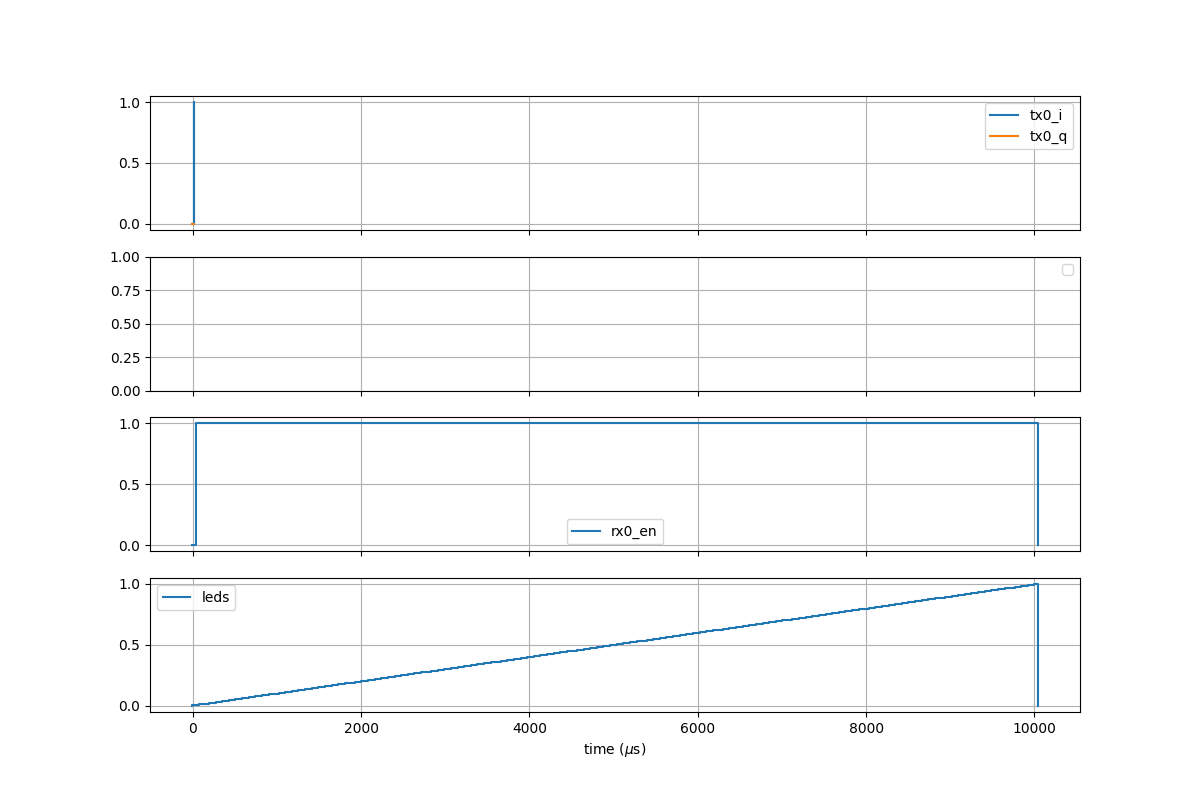

In [6]:
# Send the sequence
data = spectrometer.send_sequence(seq_simple, debug=True)

`data` contains the complex QI-demodulated data as a one dimensional `numpy` array.

Now we can put the data into a simple container with the relevant metadata and save it to a file for later processing.

In [7]:
# Create FID object
fid = FID1D(
    data=data,
    spectral_width=spectrometer.sample_rate,
    carrier_freq=0.0,
    observation_freq=spectrometer.rx_freq,
    label="1H",
    sample="Water",
    pulse="single_90_degree_pulse,length=9us,delay=30us",
    spectrometer="magnETHical v0.1",
)

# Save to file
time = fid.timestamp.strftime("%Y%m%d-%H%M%S")
file = Path(f"../../data/{time}-{fid.sample}-{fid.label}-{fid.pulse}.fid")
fid.to_file(file)

The data is stored in standard `nmrpipe` format, thus further analysis can be conducted in any other tooling capable of reading that format.

For more features and further information, see the various `record_*` and `process_` scripts in the `scripts` folder and the library reference.

In [22]:
# Stop the server
server.stop()

## Analyzing the received signal

Having conducted all of our experiments, we can load the data from file to analyze it. 

- outside of Python, e.g. in `NMRPipe`,
- in Python using e.g. `nmrglue`, `numpy`, `scipy`, `matplotlib`, ... or
- any tooling that can read `NMRPipe` `.fid` files

### Loading the data back into Python

We'll now quickly look at the data with some small helper functions built around `nmrglue`

In [8]:
# Load data back from file
fid = FID1D.from_file(file)

### Plot the data

Now we can plot the time domain data

Requested font Merriweather Sans doesn't exist! Using defaults.


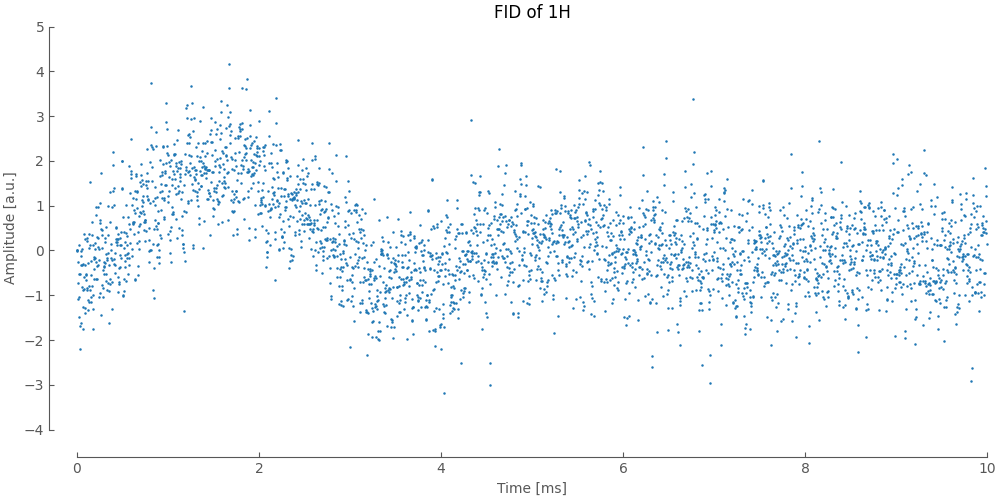

In [9]:
# Take a quick look at the time domain data (i.e. the FID)
fig = fid.plot()

Requested font Merriweather Sans doesn't exist! Using defaults.


Amplitude: 3.174344472891449
Frequency: 0.032517995029137096
Phase: -0.4949810588409244
Offset: 0.06972268759402746


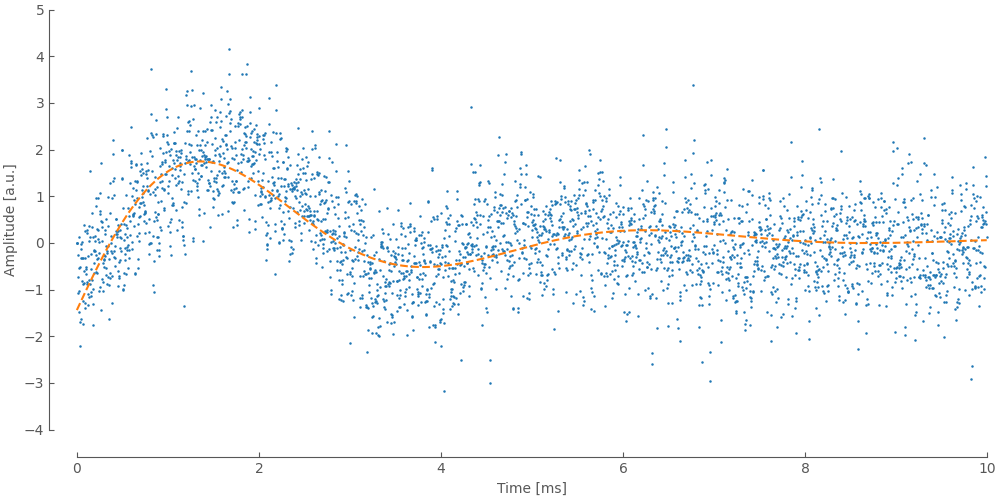

In [12]:
# Try to plot simple least squares fit for a decaying sinusoid
fit_decaying_sinusoid = process.fit_decaying_sinusoid(fid.ms_scale, fid.data.real)
ms_scale_fine = np.linspace(fid.ms_scale[0], fid.ms_scale[-1], len(fid.ms_scale) * 10)

print(f"Amplitude: {fit_decaying_sinusoid['amplitude']}")
print(f"Frequency: {fit_decaying_sinusoid['frequency'] / (2*np.pi)}")
print(f"Phase: {fit_decaying_sinusoid['phase']}")
print(f"Offset: {fit_decaying_sinusoid['offset']}")

# Plot manually
fig, axes = plot.subplots(figsize=(10,5))
axes.set_ylabel("Amplitude [a.u.]")
axes.set_xlabel("Time [ms]")

# Plot raw values again
axes.plot(
    fid.ms_scale,
    fid.data.real,
    linestyle="",
    marker="o",
    markersize=0.8,
)

# Plot fit
axes.plot(
    ms_scale_fine,
    fit_decaying_sinusoid["function"](ms_scale_fine),
    linestyle="--",
)

plot.format_axes(axes, font="Merriweather Sans")

There's also a function to quickly get a simple spectrum.

This function does
- zero-fill
- complex fft
- simple automatic phase correction
    - by minimizing the peaks around the highest maximum

Requested font Merriweather Sans doesn't exist! Using defaults.


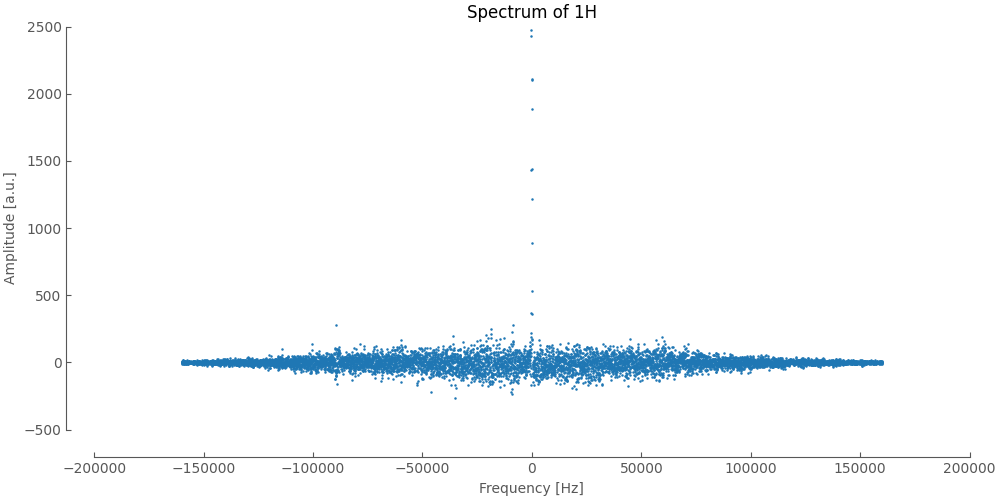

In [13]:
# Take a quick look at the spectrum
# (includes an auto zero-fill, complex fft and simple auto phase correction)
fig = fid.plot_simple_fft()

We should probably crop the data a bit so we can see the peak better.

Requested font Merriweather Sans doesn't exist! Using defaults.


Zero-order phase shift: -109.60781250000015


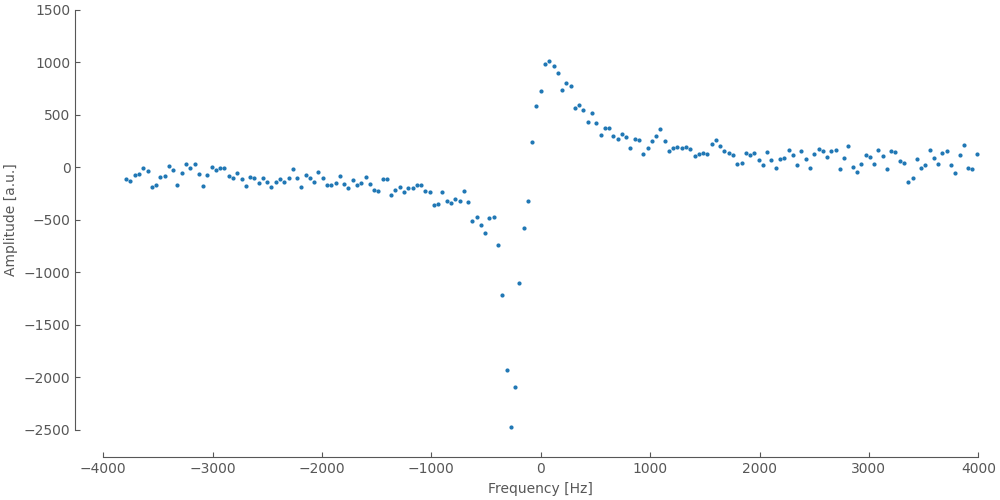

In [25]:
# FFT
hz_scale, fft_vals = fid.simple_fft(phase_shift_kwargs=False) 
print(f"Zero-order phase shift: {p0}")
# We can also manually specify the zero-order phase shift by passing `phase_shift_kwargs={"p0": 68}`

# Crop
peak = np.argmax(fft_vals)
peak_hz_scale = hz_scale[peak-100:peak+100]
peak_fft_vals = fft_vals[peak-100:peak+100]

# Plot manually
fig, axes = plot.subplots(figsize=(10,5))
axes.plot(
    peak_hz_scale,
    peak_fft_vals.real,
    linestyle="",
    marker="o",
    markersize=2,
)
axes.set_ylabel("Amplitude [a.u.]")
axes.set_xlabel("Frequency [Hz]")

plot.format_axes(axes, font="Merriweather Sans")

### Do a fit

Now we can take the peak and try to do a Lorentz fit to get some interesting paramters:

- amplitude
- position
- peak width (gamma)

Requested font Merriweather Sans doesn't exist! Using defaults.


Amplitude: 2569.5330041195657
Gamma: 108.77030994297714 Hz
Position: -155.62113946026432 Hz


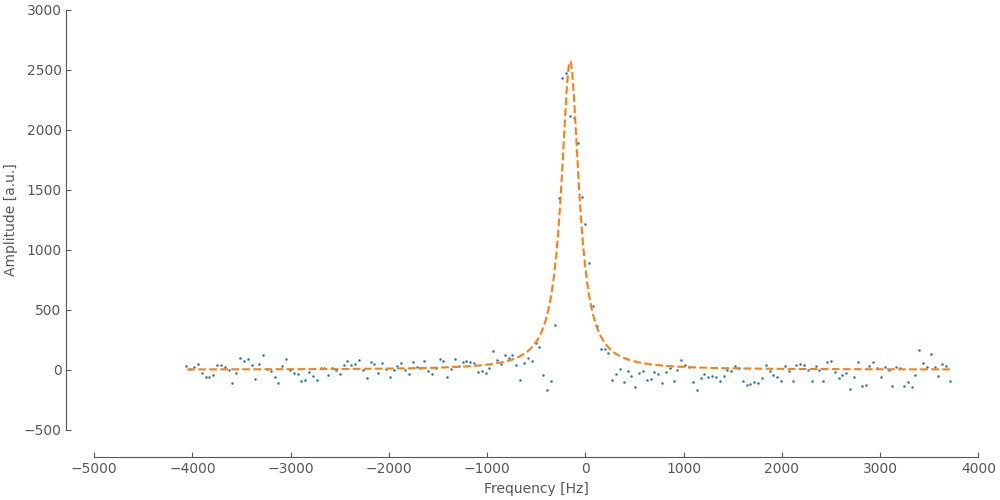

/home/mstabel/Projects/nmr-spectrometer/software/spectrometer/.venv/lib/python3.11/site-packages/ipympl/backend_nbagg.py:279: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  self.manager.handle_json(content)


In [15]:
# Try to plot simple least squares fit for a lorentzian peak
fit_decaying_sinusoid = process.fit_lorentz(peak_hz_scale, peak_fft_vals.real)
ms_scale_fine = np.linspace(peak_hz_scale[0], peak_hz_scale[-1], len(peak_hz_scale) * 10)

print(f"Amplitude: {fit_decaying_sinusoid['amplitude']}")
print(f"Gamma: {fit_decaying_sinusoid['gamma']} Hz")
print(f"Position: {fit_decaying_sinusoid['position']} Hz")

# Plot manually
fig, axes = plot.subplots(figsize=(10,5))
axes.set_ylabel("Amplitude [a.u.]")
axes.set_xlabel("Frequency [Hz]")

# Plot raw values again
axes.plot(
    peak_hz_scale,
    peak_fft_vals.real,
    linestyle="",
    marker="o",
    markersize=2,
)

# Plot fit
axes.plot(
    ms_scale_fine,
    fit_decaying_sinusoid["function"](ms_scale_fine),
    linestyle="--",
)

plot.format_axes(axes, font="Merriweather Sans")